In [140]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib
import shap
import time
import seaborn

import sys
sys.path.insert(1, r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning')

import FunctionCollection as fc
fc = importlib.reload(fc)
import os
import sqlite3
import torch
import captum.attr as c
from tqdm import tqdm

In [2]:
path = r'C:\Users\jv97\Desktop\github\Neutrino-Machine-Learning'

run_name = 'OscNext_Angle_m27'

args = {'N_edge_feats': 6,
        'N_dom_feats': 7,
        'N_targets': 2,
        'N_outputs': 3,
        'N_metalayers': 2,
        'N_hcs': 64,
        'diagonal_cov': True,
        'wandb_activated': False,
        'type': 'Spherical_NLLH',
        'zenith': True,
        'id': '23ge',#wandb.util.generate_id()[:4],
        'eps': 1e-5,
        'output_offset': [3.14,1.57],
        'lr': 0.0209,
        'filename': 'dev_lvl7_mu_nu_e_classification_v003_unscaled.db',#dev_level7_mu_e_tau_oscweight_000.db #rasmus_classification_muon_3neutrino_3mio.db #dev_level7_oscNext_IC86_003.db
        'features': 'width, rqe, charge_log10, dom_time, dom_x, dom_y, dom_z',
        'targets': 'azimuth, zenith, energy_log10',
        'TrTV': (0,1,1)
       }

In [3]:
filepath = os.path.join(path,'raw_data')

centers = pd.DataFrame({'charge_log10': [-0.033858],
                        'dom_time': [10700.0],
                        'dom_x': [0],
                        'dom_y': [0],
                        'dom_z': [0],
                        'width': [4.5],
                        'rqe': [1.175]})
scalers = pd.DataFrame({'charge_log10': [0.274158],
                        'dom_time': [2699.0],
                        'dom_x': [300],
                        'dom_y': [300],
                        'dom_z': [300],
                        'width': [3.5],
                        'rqe': [0.175]})

centers = centers[args['features'].split(', ')].values
scalers = scalers[args['features'].split(', ')].values

def x_transform(df):
    df = (df - centers)/scalers
    return torch.tensor(df.values)

def y_transform(df):
    return torch.tensor(df.values)

dataset = fc.custom_db_dataset(filepath = filepath,
                               filename = args['filename'],
                               features = args['features'],
                               targets = args['targets'],
                               TrTV = args['TrTV'],
                               x_transform = x_transform,
                               y_transform = y_transform,
                               shuffle = False)

In [45]:
device = torch.device('cuda')

import Model_Loaders.Model_27 as M
M = importlib.reload(M)

Net = M.Load_model(args['type'],args)
model = Net.load_from_checkpoint(path + '/checkpoints/' + run_name + '_' + args['id'] + '/' + run_name + '_latest.ckpt')
model.eval();
model.to(device);

if features = x, Charge should be at x[:,-5], time at x[:,-4] and pos at x[:,-3:]
Remember all accuracies are positive and defined to go towards 0 in the optimal case.


In [46]:
test = dataset[5192].to(device)
test2 = dataset[5193].to(device)

In [37]:
tuple(item.x for item in sample)[0]

tensor([[ 1.0000,  1.0000,  1.3089, -0.2519,  0.1543, -0.1163, -0.9967],
        [ 1.0000,  1.0000,  3.3151,  0.1764,  0.1543, -0.1163, -1.5073],
        [ 1.0000, -1.0000,  5.5036, -0.1830,  0.1042, -0.2431, -0.7874],
        [ 1.0000,  1.0000,  1.3089,  0.2405,  0.2412, -0.2220, -1.1869],
        [ 1.0000,  1.0000,  4.7741, -0.0622,  0.1387,  0.1183, -0.6899],
        [-1.0000,  1.0000,  3.3151, -0.2386,  0.1387,  0.1183, -0.7833],
        [-1.0000,  1.0000,  3.3151, -0.2727,  0.1387,  0.1183, -0.8300],
        [-1.0000,  1.0000,  1.1266, -0.3053,  0.1387,  0.1183, -0.9001],
        [-1.0000,  1.0000,  2.9503, -0.2579,  0.1387,  0.1183, -0.9468],
        [ 1.0000,  1.0000,  4.5917, -0.1578,  0.1387,  0.1183, -1.1337],
        [ 1.0000,  1.0000,  4.4093, -0.1782,  0.1387,  0.1183, -1.2739],
        [ 1.0000,  1.0000,  6.4155, -0.2712,  0.3565,  0.0903, -0.8629],
        [ 1.0000,  1.0000,  2.0385, -0.2842,  0.3565,  0.0903, -0.9330],
        [ 1.0000,  1.0000,  3.8622, -0.2801,  0.356

In [82]:
tmp[0].x.requires_grad

False

In [172]:
explainer = c.Saliency(model)
def create_sample(N,batch_size=3,N_features=args['N_dom_feats'],N_targets=args['N_outputs']):
    event_ids = np.random.choice(dataset.__len__(),N).tolist()
    loader = torch.utils.data.DataLoader(dataset[event_ids],
                                         batch_size=batch_size,
                                         collate_fn = lambda x: tuple(item.x.to(device) for item in x))
    
#     results = torch.zeros((N,N_features,N_targets))
    results = []
    for sample in tqdm(loader):
        tmp = [torch.cat([item for item in sample],0).unsqueeze(1)]
        for i in range(N_targets):
            att = explainer.attribute(sample,i)
#             tmp.append(torch.cat([item.sum(0).unsqueeze(0) for item in att],0).unsqueeze(1))
            tmp.append(torch.cat([item for item in att],0).unsqueeze(1))
        results.append(torch.cat(tmp,1))
    return torch.cat(results,dim=0)

sample = create_sample(7)
# explainer.attribute(tuple(item.x.to(device) for item in sample),0)

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 12.13it/s]


In [183]:
(sample[:,2]/sample[:,0]).mean(0).shape

torch.Size([7])

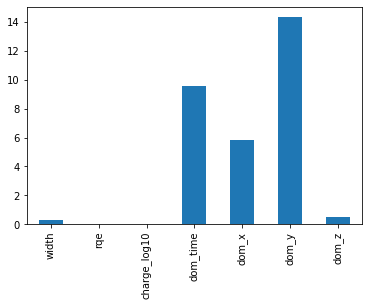

In [189]:
sample.shape
df_sample = pd.DataFrame((sample[:,1]/sample[:,0]).cpu().numpy(),columns=args['features'].split(', '))
plt.figure()
df_sample.abs().mean(0).plot.bar()

In [174]:
i = 0
(sample[:,i]/sample[:,i].sum(1).unsqueeze(1)).mean(0)

tensor([-0.1338, -0.1510,  1.4428,  0.0046,  0.0438,  0.0125, -0.2190],
       device='cuda:0', dtype=torch.float64)

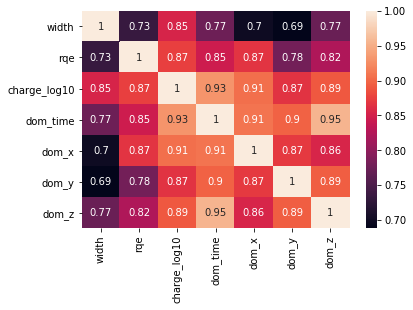

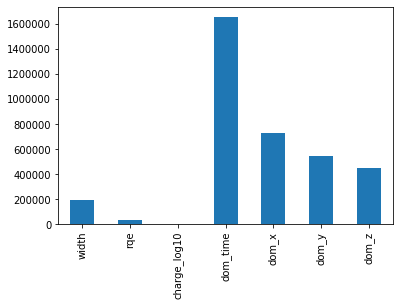

In [159]:
df = pd.DataFrame(sample[:,0].cpu().numpy(),columns=args['features'].split(', '))

seaborn.heatmap(df.corr(),annot=True)

plt.figure()
df.sum(0).plot.bar()

# fig, ax = plt.subplots()
# im = ax.matshow(df.corr())
# fig.colorbar(im)

In [105]:
torch.zeros((2,1)).unsqueeze(1).shape

torch.Size([2, 1, 1])